In [1]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_csv('spam.csv',  encoding = "ISO-8859-1")

In [3]:
df = df.drop(['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], axis = 1)

In [4]:
df.columns = ['label', 'text']

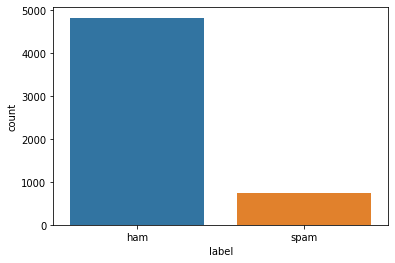

In [5]:
sns.countplot(x = df.label)

# Preprocessing

In [6]:
lb = preprocessing.LabelBinarizer()
df.label = lb.fit_transform(df.label)

In [7]:
def preprocess(text, is_lower_case = False):
    
    tokenizer = ToktokTokenizer()
    ps = nltk.porter.PorterStemmer()
    
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
        
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords.words('english')]
    filtered_text = ' '.join(filtered_tokens)
    
    text = ' '.join([ps.stem(word) for word in filtered_tokens])

    return text

In [8]:
df['text'] = df['text'].apply(preprocess)

In [9]:
X = df.text
y = df.label

In [10]:
seed = 42

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.33, random_state = seed)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3733,), (1839,), (3733,), (1839,))

In [13]:
def binary_classification_performance(y_test, y_pred, model):
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall) 
    auc_roc = round(roc_auc_score(y_score = y_pred, y_true = y_test),2)
    model_name = model
    result = pd.DataFrame({
                         'Model' : [model_name],
                         'Accuracy':[accuracy],
                         'Precision' : [precision],
                         'Recall': [recall],
                         'f1 score' : [f1_score],
                        })
    
    return result

# Bag of words

In [14]:
vect = CountVectorizer()

vect.fit(X_train)
X_train2 = vect.transform(X_train)
X_test2 = vect.transform(X_test)

In [15]:
X_train2.shape, X_test2.shape

((3733, 6310), (1839, 6310))

In [16]:
model_bow = LogisticRegression()
model_bow.fit(X_train2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
y_pred = model_bow.predict(X_test2)

In [18]:
binary_classification_performance(y_test, y_pred, 'Log Reg BoW')

,Model,Accuracy,Precision,Recall,f1 score
0,Log Reg BoW,0.97988,0.995392,0.857143,0.921109


# Tfidf

In [19]:
tv = TfidfVectorizer()
X_train3 = tv.fit_transform(X_train)
X_test3 = tv.transform(X_test)

In [20]:
X_train3.shape, X_test3.shape

((3733, 6310), (1839, 6310))

In [21]:
model_tfidf = LogisticRegression()
model_tfidf.fit(X_train3, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
y_pred = model_tfidf.predict(X_test3)

In [23]:
binary_classification_performance(y_test, y_pred, 'Log Reg- tfidf')

,Model,Accuracy,Precision,Recall,f1 score
0,Log Reg- tfidf,0.952692,0.966102,0.678571,0.797203


# Term weight for spam texts

In [24]:
df_spam = df.loc[df['label'] == 1]

In [25]:
cv = CountVectorizer()
transformer = TfidfTransformer()

In [26]:
sf = cv.fit_transform(df_spam.text)
transformed_weights = transformer.fit_transform(sf)

In [27]:
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': cv.get_feature_names(), 'weight': weights})

In [28]:
weights_df.sort_values(by = ['weight'], ascending=False)[:15]

,term,weight
943,call,0.044635
1307,free,0.034620
2445,txt,0.025735
1735,mobil,0.024834
2362,text,0.024491
2488,ur,0.023746
1015,claim,0.022777
1997,prize,0.021564
2079,repli,0.021553
2279,stop,0.021188


# Common spam bigrams

In [29]:
wv = CountVectorizer(ngram_range= (2,2), analyzer = 'word')
sparse_matrix = wv.fit_transform(df_spam.text)

In [30]:
frequencies = sum(sparse_matrix).toarray()[0]
ngram = pd.DataFrame(frequencies, index = wv.get_feature_names(), columns = ['frequency'])
ngram.nlargest(15, 'frequency')

,frequency
co uk,49
pleas call,46
tri contact,28
custom servic,27
po box,24
1000 cash,23
select receiv,20
chanc win,19
everi week,19
guaranteed call,19
